<a href="https://colab.research.google.com/github/seanreed1111/colab-demos/blob/master/btyd_test_auto_reparam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

see also: 
- https://www.briancallander.com/posts/customer_lifetime_value/pareto-nbd.html
- https://www.briancallander.com/posts/customer_lifetime_value/recency_frequency.Rmd
- https://www.briancallander.com/posts/customer_lifetime_value/recency_frequency.html
- https://github.com/mplatzer/BTYDplus/blob/master/R/pareto-nbd-mcmc.R
- https://cran.r-project.org/web/packages/BTYD/BTYD.pdf
- https://github.com/mplatzer/BTYDplus



In [1]:
# installlation required
!pip install pyro-ppl=='1.8.0' lifetimes


     |████████████████████████████████| 713 kB 4.8 MB/s 
     |████████████████████████████████| 584 kB 42.9 MB/s 


<a id = "7"></a><br>
# LIBRARIES

In [ ]:
import os
import datetime as dt
import pandas as pd
pd.set_option('display.max_rows', 50)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import logging
from scipy.stats import expon, poisson, uniform, lognorm

from numpy.random import Generator, PCG64
numpy_randomGen = Generator(PCG64(seed=1))


import torch
from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.infer import SVI,Trace_ELBO
from pyro.infer.autoguide  import AutoMultivariateNormal, AutoNormal, init_to_mean
from pyro.infer.reparam import AutoReparam
from pyro.optim import ClippedAdam

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 4]


Let’s describe the model first by simulation. 

Suppose we have a company that is 2 years old and a total of 2000 customers, C, that have made at least one purchase from us. 

We’ll assume a linear rate of customer acquisition, so that the first purchase date is simply a uniform random variable over the 2 years of the company existance. These assumptions are just to keep the example concrete, and are not so important for understanding the model.

Each customer c∈C is assumed to have a certain lifetime, τc, starting on their join-date. 

During their lifetime, they will purchase at a constant rate, λc, so that they will make k∼Poisson(tλc) purchases over a time-interval t. 

Once their lifetime is over, they will stop purchasing. We only observe the customer for Tc units of time, and this observation time can be either larger or smaller than the lifetime, τc. 

Since we don’t observe τc itself, we will assume it follows an exponential distribution, i.e. τc∼Exp(μc).

In [ ]:
logging.basicConfig(level=logging.INFO)

In [ ]:
def create_start_dates(n, max_number_of_periods):
  '''
  returns an array of n start dates in interval [0, max_number_of_periods)
  
  inputs 
  int n: number of customers to generate
  int max_number_of_periods: max number of periods customer can be observed in simulation

  output: 
  start_date[n]: starting period of customer n, starting from 0
  '''
  return np.random.default_rng(1).integers(low=0, high=max_number_of_periods, size=n)

In [ ]:
def simulate_purchases(*,T, mean_customer_lifetime, 
                       mean_period_between_purchases,
                       max_number_of_periods,
                       var_customer_lifetime = None, 
                       var_period_between_purchases = None 
                        ):
  '''
  input: 
  T: customer enrollment date

  mean_customer_lifetime: mean of customer lifetime, in periods
  var_customer_lifetime: var of customer lifetime
  mean_period_between_purchases: mean period between purchases
  var_period_between_purchases: var of period between purchases

  output:
  k: number of purchases
  T: customer enrollment date
  obs_time = This is the length of time they have been a customer, max_number_of_periods - T
  tau: actual (latent) lifetime for this customer (drawn from exponential distribution with scale=mean_customer_lifetime)
  mean_customer_lifetime: mean_customer_lifetime
  1./mean_customer_lifetime :  reciprocal of mean customer lifetime
  '''
  from scipy.stats import expon
  
  obs_time = max_number_of_periods - T
  assert obs_time > 0, "time as enrolled customer cannot be negative"
  assert mean_customer_lifetime > 0 , "mean customer lifetime must be > 0"
  assert mean_period_between_purchases > 0, "mean period between purchases must be > 0"
  
  tau = expon.rvs(scale=mean_customer_lifetime) # actual lifetime for this customer
  t, k = T, 0 
  wait = expon.rvs(scale=mean_period_between_purchases) # waiting time between purchases
  while ((t + wait) < min(max_number_of_periods, T + tau)): 
    t = t + wait
    k = k + 1
    wait = expon.rvs(scale=mean_period_between_purchases)

  return  T,  obs_time, k, tau, t, mean_customer_lifetime, 1./mean_customer_lifetime  #final value of t is time of last purchased

simulate_purchases_vec = np.vectorize(simulate_purchases)




In [ ]:
simulate_purchases(T=20.,
                   max_number_of_periods=100.,
                   mean_customer_lifetime=30.,
                   mean_period_between_purchases=8.
                   )

(20.0, 80.0, 0, 7.206151493114136, 20.0, 30.0, 0.03333333333333333)

In [ ]:
def create_customer_df(*,
                       n, 
                       mean_customer_lifetime, 
                       mean_period_between_purchases, 
                       max_number_of_periods, 
                       var_customer_lifetime = None, 
                       var_period_between_purchases = None
                       ):
  '''
  output: 
    dataframe[['enrollment_date', 
    'T_observed',
    'purchases', 
    'tau', : lifetime for this simulated customer drawn from exponential distribution with scale=mean_customer_lifetime
    'date_of_last_purchase', 
    'mean_customer_lifetime',
    '1/mean_customer_lifetime'

  '''
  T =  create_start_dates(n=n, max_number_of_periods=max_number_of_periods)
  result = np.round(
      simulate_purchases_vec(T=T, 
                             mean_customer_lifetime=mean_customer_lifetime, 
                             mean_period_between_purchases=mean_period_between_purchases,
                             max_number_of_periods=max_number_of_periods

                             )
          ,2)
  return pd.DataFrame(result, index=['enrollment_date', 
                                     'T_observed',
                                     'purchases', 
                                     'tau', 
                                     'date_of_last_purchase', 
                                     'mean_customer_lifetime',
                                     '1/mean_customer_lifetime']).T


In [ ]:
max_number_of_periods = 100
mean_customer_lifetime = 60
mean_period_between_purchases = 12
customers = create_customer_df(n=100, 
                               mean_customer_lifetime=mean_customer_lifetime, 
                               mean_period_between_purchases=mean_period_between_purchases, 
                               max_number_of_periods=max_number_of_periods)
customers

,enrollment_date,T_observed,purchases,tau,date_of_last_purchase,mean_customer_lifetime,1/mean_customer_lifetime
0,47.0,53.0,1.0,23.85,51.53,60.0,0.02
1,51.0,49.0,4.0,28.58,69.98,60.0,0.02
2,75.0,25.0,2.0,121.17,99.92,60.0,0.02
3,95.0,5.0,0.0,15.95,95.00,60.0,0.02
4,3.0,97.0,4.0,62.70,62.60,60.0,0.02
...,...,...,...,...,...,...,...
95,75.0,25.0,0.0,0.62,75.00,60.0,0.02
96,5.0,95.0,2.0,25.44,23.45,60.0,0.02
97,14.0,86.0,3.0,16.59,29.44,60.0,0.02
98,54.0,46.0,1.0,15.80,64.20,60.0,0.02


In [ ]:
customers.describe().T

,count,mean,std,min,25%,50%,75%,max
enrollment_date,100.0,50.3000,2.839423e+01,1.00,27.75,49.500,75.5000,98.00
T_observed,100.0,49.7000,2.839423e+01,2.00,24.50,50.500,72.2500,99.00
purchases,100.0,2.6600,2.590659e+00,0.00,1.00,2.000,4.0000,11.00
tau,100.0,55.2065,5.211553e+01,0.62,15.69,36.655,82.4675,274.79
date_of_last_purchase,100.0,72.3086,2.540275e+01,6.00,53.21,81.500,93.4275,99.92
mean_customer_lifetime,100.0,60.0000,0.000000e+00,60.00,60.00,60.000,60.0000,60.00
1/mean_customer_lifetime,100.0,0.0200,1.394770e-17,0.02,0.02,0.020,0.0200,0.02


In [ ]:
data = customers[customers['purchases'] >= 2.].copy()
data.describe().T

,count,mean,std,min,25%,50%,75%,max
enrollment_date,55.0,40.763636,2.613495e+01,1.00,17.00,42.00,60.000,87.00
T_observed,55.0,59.236364,2.613495e+01,13.00,40.00,58.00,83.000,99.00
purchases,55.0,4.436364,2.225805e+00,2.00,3.00,4.00,6.000,11.00
tau,55.0,79.313091,5.552055e+01,4.50,32.48,66.42,114.065,274.79
date_of_last_purchase,55.0,78.356909,2.328237e+01,12.61,67.64,87.89,96.020,99.92
mean_customer_lifetime,55.0,60.000000,0.000000e+00,60.00,60.00,60.00,60.000,60.00
1/mean_customer_lifetime,55.0,0.020000,1.050427e-17,0.02,0.02,0.02,0.020,0.02


In [ ]:
data.head()

,enrollment_date,T_observed,purchases,tau,date_of_last_purchase,mean_customer_lifetime,1/mean_customer_lifetime
1,51.0,49.0,4.0,28.58,69.98,60.0,0.02
2,75.0,25.0,2.0,121.17,99.92,60.0,0.02
4,3.0,97.0,4.0,62.70,62.60,60.0,0.02
5,14.0,86.0,2.0,22.77,25.60,60.0,0.02
8,24.0,76.0,3.0,28.51,46.24,60.0,0.02


In [ ]:
t, T, k = tensor(data['date_of_last_purchase'].values), tensor(data['T_observed'].values), tensor(data['purchases'].values)

## Graph Potential Priors

tensor(3.2896e-05) tensor(0.0674) tensor(0.1002) tensor(0.8227) tensor(0.0113)


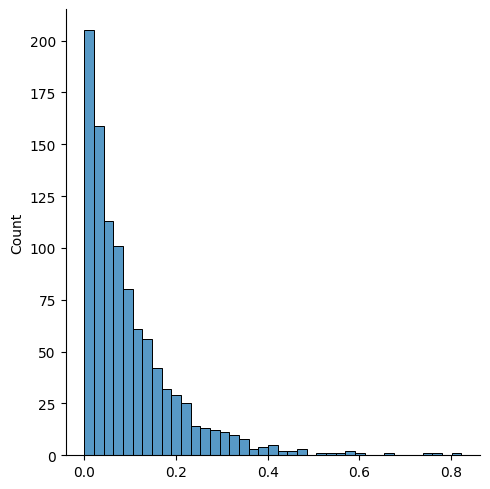

In [ ]:
# Gamma:
# mean = concentration / rate
# var = concentration / rate ^2

data=dist.Gamma(concentration=1, rate=10).expand([1000]).sample()
print(data.min(),  data.median(), data.mean(),data.max(), data.var())
sns.displot(data=data);

tensor(3.4028) tensor(10.4677) tensor(11.6339) tensor(86.2276) tensor(27.7864)


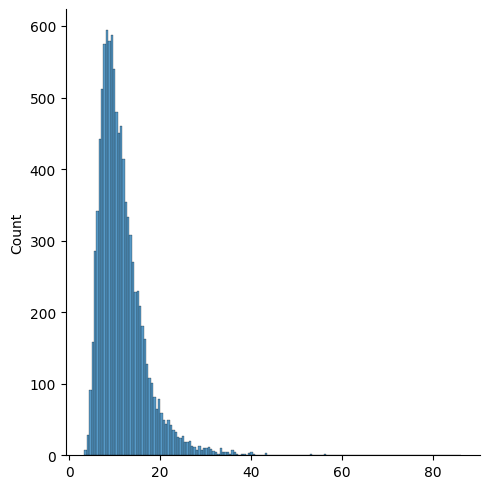

In [ ]:
# Inverse Gamma: for concentration > 2, 
#     mean = rate/(concentration - 1)
#      var ~ concentration^2 / rate ^3
#     MEDIAN  ~ rate / concentration

# Gamma:
# mean = concentration / rate
# var = concentration / rate ^2

data=dist.InverseGamma(concentration=7,rate=70.).expand([10000]).sample()

print(data.min(),  data.median(), data.mean(), data.max(), data.var())
sns.displot(data=data);

tensor(0.0074) tensor(33.6056) tensor(39.9393) tensor(218.2334) tensor(917.1815)


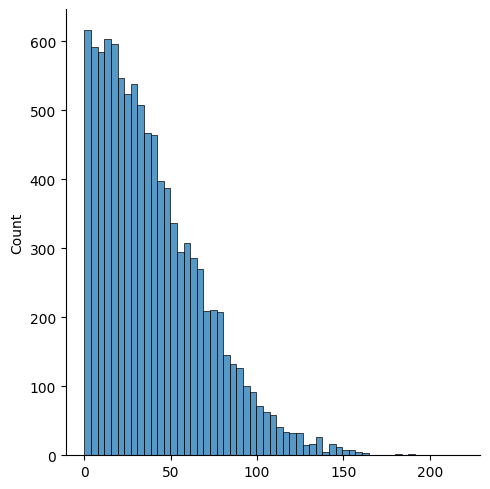

In [ ]:
data=dist.HalfNormal(scale=50).expand([10000]).sample()

print(data.min(),  data.median(), data.mean(), data.max(), data.var())
sns.displot(data=data);

## Model Definition

In [ ]:
# compute priors


In [ ]:
@AutoReparam(centered=0.)
def model(t, T, k, prior_only=False):
  '''
  input:
  vector t (nx1)  = time since most recent purchase (recency)
  vector T (nx1) = total observation time
  vector k (nx1) = number of purchases observed (k must be >= 2)

  n, etau_alpha, etau_beta, Lambda_alpha, Lambda_beta are scalars
  n = number of customers
  etau_alpha, etau_beta are priors for etau
  Lambda_alpha, Lambda_beta are priors for Lambda
  '''
  assert torch.all(k >=2.), "There are illegal values of k. k must be >= 2"

  def loglik(Lambda, mu, t, T, k):
    target = k * torch.log(Lambda) - torch.log(Lambda + mu)
    n = Lambda.size(0)
    for i in range(n):
      target  = target + torch.logaddexp(torch.log(Lambda[i]) - (Lambda[i] + mu[i]) * T[i],
                                        torch.log(mu[i]) - (Lambda[i] + mu[i]) * t[i]
                                        )
    return target
  
  etau_alpha = pyro.sample('etau_alpha', dist.Uniform(0.75,1.25)) #mean customer lifetime

  etau_beta = pyro.sample('etau_beta', dist.HalfNormal(scale=100.))
  Lambda_alpha = pyro.sample('Lambda_alpha', dist.Uniform(0.75,1.25))  #lambda = purchase rate 
  Lambda_beta =pyro.sample('Lambda_beta', dist.HalfNormal(scale=50.))

  if not prior_only:
    with pyro.plate("data", t.size(0)):
      etau  = pyro.sample('etau', dist.InverseGamma(etau_alpha, etau_beta)) #mean customer lifetime
      mu = pyro.deterministic('mu', 1./etau)
      Lambda = pyro.sample('Lambda', dist.Gamma(Lambda_alpha, Lambda_beta)) #lambda = purchase rate
      one_over_Lambda = pyro.deterministic('one_over_Lambda', 1./Lambda)   #days between purchases
    pyro.factor('loglik', loglik(Lambda, mu, t, T, k))

In [ ]:
from pyro.infer import MCMC, NUTS
model = model
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=250)

mcmc.run(t, T, k, prior_only=True)

samples = mcmc.get_samples()
hmc_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
hmc_samples.keys()

Sample: 100%|██████████| 1250/1250 [00:24, 51.43it/s, step size=5.60e-01, acc. prob=0.903]


dict_keys(['Lambda_alpha', 'Lambda_beta', 'etau_alpha', 'etau_beta'])

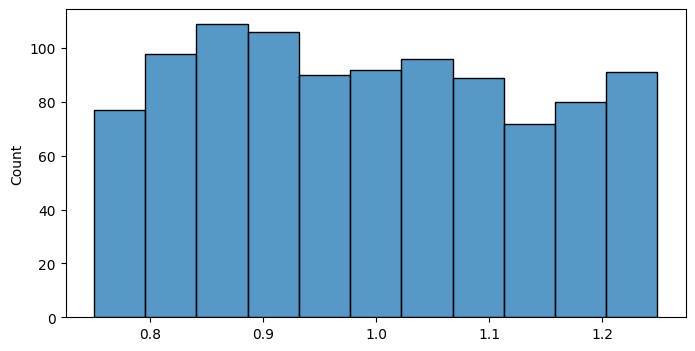

In [ ]:
sns.histplot(data=hmc_samples['Lambda_alpha']);


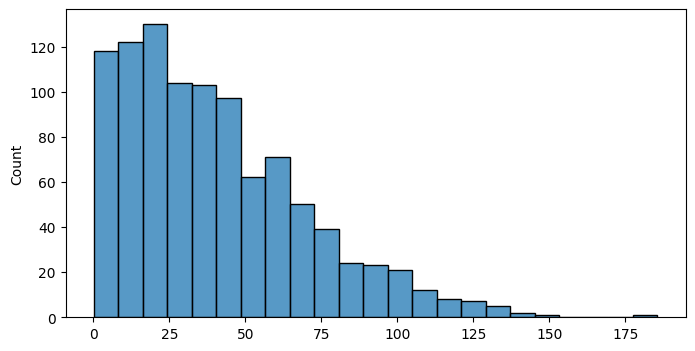

In [ ]:
sns.histplot(data=hmc_samples['Lambda_beta']);

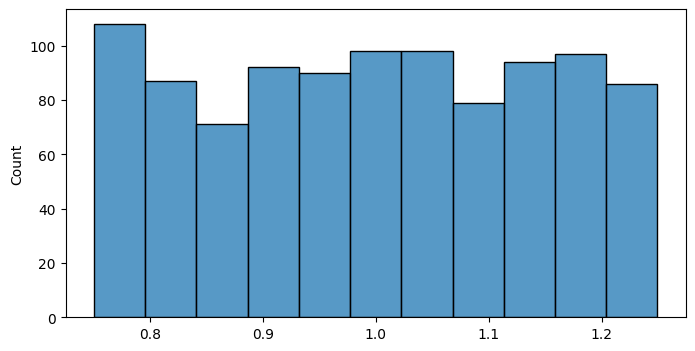

In [ ]:
sns.histplot(data=hmc_samples['etau_alpha']);

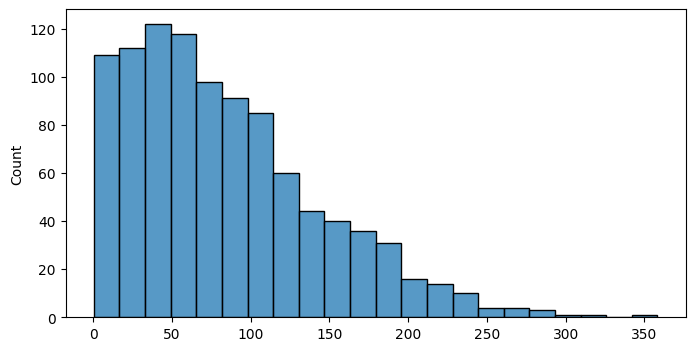

In [ ]:
sns.histplot(data=hmc_samples['etau_beta']);

In [ ]:
model = model
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100)

mcmc.run(t, T, k, prior_only=False)

Sample: 100%|██████████| 1100/1100 [07:03,  2.60it/s, step size=2.30e-01, acc. prob=0.807]


In [ ]:
samples = mcmc.get_samples()
hmc_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}

In [ ]:
hmc_samples.keys()

dict_keys(['Lambda', 'Lambda_alpha', 'Lambda_beta', 'etau_alpha', 'etau_base', 'etau_beta'])

In [ ]:
np.savetxt('etau.gz', hmc_samples['etau_base'], delimiter=',')
np.savetxt('etau_beta.gz', hmc_samples['etau_beta'], delimiter=',')
np.savetxt('etau_alpha.gz', hmc_samples['etau_alpha'], delimiter=',')
np.savetxt('lambda.gz', hmc_samples['Lambda'], delimiter=',')
np.savetxt('lambda_alpha.gz', hmc_samples['Lambda_alpha'], delimiter=',')
np.savetxt('lambda_beta.gz', hmc_samples['Lambda_beta'], delimiter=',')


In [ ]:
# model = model
# nuts_kernel_jit = NUTS(model, jit_compile=True)
# mcmc_jit = MCMC(nuts_kernel_jit, num_samples=5000, warmup_steps=500)

# mcmc_jit.run(t, T, k)
# samples_jit = mcmc_jit.get_samples()
# hmc_samples_jit = {k: v.detach().cpu().numpy() for k, v in samples_jit.items()}

# np.savetxt('etau.gz', hmc_samples_jit['etau_base'], delimiter=',')
# np.savetxt('etau_beta.gz', hmc_samples_jit['etau_beta'], delimiter=',')
# np.savetxt('etau_alpha.gz', hmc_samples_jit['etau_alpha'], delimiter=',')
# np.savetxt('lambda.gz', hmc_samples_jit['Lambda'], delimiter=',')
# np.savetxt('lambda_alpha.gz', hmc_samples_jit['Lambda_alpha'], delimiter=',')
# np.savetxt('lambda_beta.gz', hmc_samples_jit['Lambda_beta'], delimiter=',')


In [ ]:
t, T, k

(tensor([69.9800, 99.9200, 62.6000, 25.6000, 46.2400, 72.1800, 89.1900, 94.1100,
         98.3700, 46.7600, 83.5500, 97.8900, 97.5000, 61.5500, 79.7300, 99.6800,
         82.3800, 92.6200, 99.0400, 87.8900, 97.7700, 91.3500, 85.0000, 50.2300,
         70.9600, 91.8000, 41.3100, 68.0400, 25.9500, 12.6100, 91.9600, 63.2100,
         79.6100, 91.3600, 99.3700, 89.0600, 95.1300, 82.8700, 93.1500, 92.8400,
         96.4600, 83.5100, 95.1700, 99.8000, 66.4700, 76.8900, 85.4400, 97.0500,
         95.5900, 99.4600, 96.8500, 96.4500, 67.2400, 23.4500, 29.4400],
        dtype=torch.float64),
 tensor([49., 25., 97., 86., 76., 58., 73., 75., 46., 92., 98., 14., 17., 47.,
         68., 55., 88., 88., 55., 87., 62., 80., 50., 74., 99., 25., 72., 52.,
         89., 91., 28., 73., 68., 58., 89., 55., 23., 39., 23., 58., 97., 29.,
         13., 55., 64., 55., 23., 79., 41., 20., 17., 33., 49., 95., 86.],
        dtype=torch.float64),
 tensor([ 4.,  2.,  4.,  2.,  3.,  6.,  7.,  5.,  6.,  7., 11.,  2., 

In [ ]:
Lambda = pd.DataFrame(hmc_samples['Lambda'])
mu = pd.DataFrame(1. /hmc_samples['Lambda'])
tau = pd.DataFrame(hmc_samples['etau_base'])

In [ ]:
Lambda.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1000.0,0.020748,0.002821,0.013834,0.018787,0.020660,0.022469,0.030584
1,1000.0,0.039841,0.005146,0.025367,0.036138,0.039574,0.043393,0.060663
2,1000.0,0.003335,0.001354,0.000701,0.002360,0.003189,0.004082,0.008599
3,1000.0,0.002330,0.001328,0.000222,0.001370,0.002057,0.003075,0.007928
4,1000.0,0.003374,0.001652,0.000348,0.002173,0.003090,0.004302,0.012909
...,...,...,...,...,...,...,...,...
50,1000.0,0.058679,0.007684,0.036697,0.053008,0.058742,0.063800,0.081524
51,1000.0,0.030281,0.004403,0.017640,0.027272,0.030154,0.033114,0.048483
52,1000.0,0.021349,0.002893,0.012757,0.019472,0.021342,0.023166,0.030805
53,1000.0,0.002431,0.001342,0.000174,0.001443,0.002193,0.003134,0.009566


In [ ]:
mu.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1000.0,49.108642,6.832279,32.697287,44.506575,48.402653,53.229448,72.286738
1,1000.0,25.523177,3.334071,16.484570,23.044953,25.268921,27.671613,39.422032
2,1000.0,358.186724,171.138614,116.286510,244.969165,313.612022,423.775276,1426.764425
3,1000.0,628.463520,495.762367,126.130771,325.218776,486.064950,730.066529,4505.821329
4,1000.0,391.121545,263.877190,77.463478,232.423972,323.636815,460.090725,2877.523038
...,...,...,...,...,...,...,...,...
50,1000.0,17.340172,2.314698,12.266276,15.673964,17.023464,18.865211,27.250274
51,1000.0,33.742928,5.081470,20.625620,30.198926,33.163330,36.667441,56.688995
52,1000.0,47.728380,6.678595,32.462764,43.166139,46.855318,51.356781,78.388800
53,1000.0,605.634731,549.581941,104.539754,319.036137,455.998934,692.846443,5731.576242


In [ ]:
tau.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1000.0,0.000638,0.000750,7.065065e-08,0.000129,0.000363,0.000883,0.006581
1,1000.0,0.000513,0.000589,3.281309e-07,0.000089,0.000318,0.000713,0.004472
2,1000.0,0.012368,0.002391,4.972453e-03,0.010708,0.012368,0.014020,0.021378
3,1000.0,0.035022,0.005013,2.133211e-02,0.031619,0.034637,0.038278,0.050344
4,1000.0,0.017490,0.003109,6.930584e-03,0.015409,0.017285,0.019673,0.027060
...,...,...,...,...,...,...,...,...
50,1000.0,0.000691,0.000826,1.075286e-07,0.000138,0.000400,0.000943,0.006003
51,1000.0,0.000444,0.000525,1.860033e-07,0.000089,0.000267,0.000609,0.004637
52,1000.0,0.000625,0.000680,2.602941e-08,0.000134,0.000366,0.000907,0.004928
53,1000.0,0.038305,0.005356,2.385815e-02,0.034415,0.038013,0.041946,0.058524


In [ ]:
data

,enrollment_date,T_observed,purchases,tau,date_of_last_purchase,mean_customer_lifetime,1/mean_customer_lifetime
1,51.0,49.0,4.0,28.58,69.98,60.0,0.02
2,75.0,25.0,2.0,121.17,99.92,60.0,0.02
4,3.0,97.0,4.0,62.70,62.60,60.0,0.02
5,14.0,86.0,2.0,22.77,25.60,60.0,0.02
8,24.0,76.0,3.0,28.51,46.24,60.0,0.02
...,...,...,...,...,...,...,...
89,83.0,17.0,3.0,21.68,96.85,60.0,0.02
92,67.0,33.0,2.0,274.79,96.45,60.0,0.02
93,51.0,49.0,5.0,26.94,67.24,60.0,0.02
96,5.0,95.0,2.0,25.44,23.45,60.0,0.02


In [ ]:
pd.set_option('display.max_rows', 40)

In [ ]:
pd.concat([data.reset_index(),mu.describe().T ], axis=1)

,index,enrollment_date,T_observed,purchases,tau,date_of_last_purchase,mean_customer_lifetime,1/mean_customer_lifetime,count,mean,std,min,25%,50%,75%,max
0,1,51.0,49.0,4.0,28.58,69.98,60.0,0.02,1000.0,49.108642,6.832279,32.697287,44.506575,48.402653,53.229448,72.286738
1,2,75.0,25.0,2.0,121.17,99.92,60.0,0.02,1000.0,25.523177,3.334071,16.484570,23.044953,25.268921,27.671613,39.422032
2,4,3.0,97.0,4.0,62.70,62.60,60.0,0.02,1000.0,358.186724,171.138614,116.286510,244.969165,313.612022,423.775276,1426.764425
3,5,14.0,86.0,2.0,22.77,25.60,60.0,0.02,1000.0,628.463520,495.762367,126.130771,325.218776,486.064950,730.066529,4505.821329
4,8,24.0,76.0,3.0,28.51,46.24,60.0,0.02,1000.0,391.121545,263.877190,77.463478,232.423972,323.636815,460.090725,2877.523038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,89,83.0,17.0,3.0,21.68,96.85,60.0,0.02,1000.0,17.340172,2.314698,12.266276,15.673964,17.023464,18.865211,27.250274
51,92,67.0,33.0,2.0,274.79,96.45,60.0,0.02,1000.0,33.742928,5.081470,20.625620,30.198926,33.163330,36.667441,56.688995
52,93,51.0,49.0,5.0,26.94,67.24,60.0,0.02,1000.0,47.728380,6.678595,32.462764,43.166139,46.855318,51.356781,78.388800
53,96,5.0,95.0,2.0,25.44,23.45,60.0,0.02,1000.0,605.634731,549.581941,104.539754,319.036137,455.998934,692.846443,5731.576242


In [ ]:
pd.concat([data.reset_index(),Lambda.describe().T ], axis=1)

,index,enrollment_date,T_observed,purchases,tau,date_of_last_purchase,mean_customer_lifetime,1/mean_customer_lifetime,count,mean,std,min,25%,50%,75%,max
0,1,51.0,49.0,4.0,28.58,69.98,60.0,0.02,1000.0,0.020748,0.002821,0.013834,0.018787,0.020660,0.022469,0.030584
1,2,75.0,25.0,2.0,121.17,99.92,60.0,0.02,1000.0,0.039841,0.005146,0.025367,0.036138,0.039574,0.043393,0.060663
2,4,3.0,97.0,4.0,62.70,62.60,60.0,0.02,1000.0,0.003335,0.001354,0.000701,0.002360,0.003189,0.004082,0.008599
3,5,14.0,86.0,2.0,22.77,25.60,60.0,0.02,1000.0,0.002330,0.001328,0.000222,0.001370,0.002057,0.003075,0.007928
4,8,24.0,76.0,3.0,28.51,46.24,60.0,0.02,1000.0,0.003374,0.001652,0.000348,0.002173,0.003090,0.004302,0.012909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,89,83.0,17.0,3.0,21.68,96.85,60.0,0.02,1000.0,0.058679,0.007684,0.036697,0.053008,0.058742,0.063800,0.081524
51,92,67.0,33.0,2.0,274.79,96.45,60.0,0.02,1000.0,0.030281,0.004403,0.017640,0.027272,0.030154,0.033114,0.048483
52,93,51.0,49.0,5.0,26.94,67.24,60.0,0.02,1000.0,0.021349,0.002893,0.012757,0.019472,0.021342,0.023166,0.030805
53,96,5.0,95.0,2.0,25.44,23.45,60.0,0.02,1000.0,0.002431,0.001342,0.000174,0.001443,0.002193,0.003134,0.009566


In [ ]:
pd.concat([data.reset_index(), mu.describe().T ], axis=1)

,index,enrollment_date,T_observed,purchases,tau,date_of_last_purchase,mean_customer_lifetime,1/mean_customer_lifetime,count,mean,std,min,25%,50%,75%,max
0,1,51.0,49.0,4.0,28.58,69.98,60.0,0.02,1000.0,49.108642,6.832279,32.697287,44.506575,48.402653,53.229448,72.286738
1,2,75.0,25.0,2.0,121.17,99.92,60.0,0.02,1000.0,25.523177,3.334071,16.484570,23.044953,25.268921,27.671613,39.422032
2,4,3.0,97.0,4.0,62.70,62.60,60.0,0.02,1000.0,358.186724,171.138614,116.286510,244.969165,313.612022,423.775276,1426.764425
3,5,14.0,86.0,2.0,22.77,25.60,60.0,0.02,1000.0,628.463520,495.762367,126.130771,325.218776,486.064950,730.066529,4505.821329
4,8,24.0,76.0,3.0,28.51,46.24,60.0,0.02,1000.0,391.121545,263.877190,77.463478,232.423972,323.636815,460.090725,2877.523038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,89,83.0,17.0,3.0,21.68,96.85,60.0,0.02,1000.0,17.340172,2.314698,12.266276,15.673964,17.023464,18.865211,27.250274
51,92,67.0,33.0,2.0,274.79,96.45,60.0,0.02,1000.0,33.742928,5.081470,20.625620,30.198926,33.163330,36.667441,56.688995
52,93,51.0,49.0,5.0,26.94,67.24,60.0,0.02,1000.0,47.728380,6.678595,32.462764,43.166139,46.855318,51.356781,78.388800
53,96,5.0,95.0,2.0,25.44,23.45,60.0,0.02,1000.0,605.634731,549.581941,104.539754,319.036137,455.998934,692.846443,5731.576242


## Centered BTYD

In [ ]:

# https://www.briancallander.com/posts/customer_lifetime_value/models/rf.stan
# data_hyperpriors <- list(
#   log_life_mean_mu = log(31),
#   log_life_mean_sigma = 0.7,
#   log_life_scale_sigma = 0.8,

#   log_lambda_mean_mu = log(1 / 14),
#   log_lambda_mean_sigma = 0.3,
#   log_lambda_scale_sigma = 0.5
# )
data {
  int<lower = 1> n;       // number of customers
  vector<lower = 0>[n] t; // time to most recent purchase
  vector<lower = 0>[n] T; // total observation time
  vector<lower = 0>[n] k; // number of purchases observed

  // user-specified parameters
  real<lower = 0> etau_mean_alpha;
  real<lower = 0> etau_mean_beta;
  real<lower = 0> etau_sd_alpha;
  real<lower = 0> etau_sd_beta;

  real<lower = 0> lambda_mean_alpha;
  real<lower = 0> lambda_mean_beta;
  real<lower = 0> lambda_sd_alpha;
  real<lower = 0> lambda_sd_beta;
}

parameters {
  vector<lower = 0>[n] lambda; // purchase rate
  vector<lower = 0>[n] etau;   // expected mean lifetime

  vector<lower = 0>[n] etau_mean; // mean expected life span
  vector<lower = 0>[n] etau_sd;
  vector<lower = 0>[n] lambda_mean; // mean purchase rate
  vector<lower = 0>[n] lambda_sd;

}

transformed parameters {
  vector<lower = 0>[n] etau_beta = etau_mean;
  vector<lower = 0>[n] etau_alpha = etau_sd;
  vector<lower = 0>[n] lambda_beta = lambda_mean ./ (lambda_sd .* lambda_sd);
  vector<lower = 0>[n] lambda_alpha = lambda_beta .* lambda_mean;

  vector<lower = 0>[n] mu = 1.0 ./ etau;
}

model {
  // hyperpriors
  etau_mean ~ gamma(etau_mean_alpha, etau_mean_beta);
  etau_sd ~ gamma(etau_sd_alpha, etau_sd_beta);

  lambda_mean ~ gamma(lambda_mean_alpha, lambda_mean_beta);
  lambda_sd ~ gamma(lambda_sd_alpha, lambda_sd_beta);

  // priors
  etau ~ inv_gamma(etau_alpha, etau_beta);
  lambda ~ gamma(lambda_alpha, lambda_beta);

  // likelihood
  target += k .* log(lambda) - log(lambda + mu);
  for (i in 1:n) {
    target += log_sum_exp(
      log(lambda[i]) - (lambda[i] + mu[i]) .* T[i],
      log(mu[i]) - (lambda[i] + mu[i]) .* t[i]
    );
  }
}
